### Libraries

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

### Class def

In [4]:
# Imlementing SLIC algorithm
# SLIC : Simple Linear Iterative Clustering

class SLIC:
    def __init__(self, image, K, M, threshold, max_iter = 30, color_space = 'LAB', show_images = True, cluster_centers = None):
        self.image = image
        self.K = K
        self.M = M
        self.max_iter = max_iter
        self.threshold = threshold
        self.color_space = color_space
        self.show_images = show_images
        self.cluster_centers = cluster_centers
    
    def initialize_clusters(self):
        # Randomly Assign cluster centers LABXY values, K in number
        # Initialise Cluster centers as 5D np array
        cluster_centers = np.zeros((self.K, 5))
        for i in range(self.K):
            # Cluster Centers are 5D vectors for LABXY values these are randomly initialized
            if (self.color_space == 'LAB'):
                L = np.random.rand() * 100 # L value
                A = np.random.rand() * 255 - 128
                B = np.random.rand() * 255 - 128
                X = np.random.randint(0, self.image.shape[0]) # X represents row 
                Y = np.random.randint(0, self.image.shape[1]) # Y represents column
                cluster_centers[i] = np.array([L, A, B, X, Y])
            
            elif (self.color_space == 'RGB'):
                R = np.random.rand() * 255
                G = np.random.rand() * 255
                B = np.random.rand() * 255
                X = np.random.randint(0, self.image.shape[0])
                Y = np.random.randint(0, self.image.shape[1])
                cluster_centers[i] = np.array([R, G, B, X, Y])
            
            else:
                raise ValueError("Invalid Color Space")

        return cluster_centers 


    def assign_clusters(self, cluster_centers=None):
        S = np.sqrt((self.image.shape[0] * self.image.shape[1]) / self.K)
        if cluster_centers is None:
            cluster_centers = self.initialize_clusters()
        
        # Final Assignment array
        assignment_map = np.full((self.image.shape[0], self.image.shape[1]), -1)

        # Initial min distance for all pixels is infinity
        lowest_distance_map = np.full((self.image.shape[0], self.image.shape[1]), np.inf)

        for i, cluster_center in enumerate(cluster_centers):
            x1 = max(0, int(cluster_center[3] - S))
            x2 = min(self.image.shape[0], int(cluster_center[3] + S))
            y1 = max(0, int(cluster_center[4] - S))
            y2 = min(self.image.shape[1], int(cluster_center[4] + S))

            # Extract LAB channels in the window
            window = self.image[x1:x2, y1:y2]

            # Create a meshgrid for X, Y coordinates
            X, Y = np.meshgrid(np.arange(y1, y2), np.arange(x1, x2), indexing='xy')

            # Compute LAB distance
            dL = window[..., 0] - cluster_center[0]  # L channel , R if RGB
            dA = window[..., 1] - cluster_center[1]  # A channel , G if RGB   
            dB = window[..., 2] - cluster_center[2]  # B channel , B if RGB
            lab_dist = np.sqrt(dL**2 + dA**2 + dB**2) # Euclidean distance

            # Compute spatial distance
            dX = X - cluster_center[4]
            dY = Y - cluster_center[3]
            xy_dist = np.sqrt(dX**2 + dY**2)

            # Compute final distance using compactness factor
            compact_factor = self.M / S
            distances = lab_dist + compact_factor * xy_dist

            # Update assignment map and lowest distance map using vectorized masking
            mask = distances < lowest_distance_map[x1:x2, y1:y2]
            lowest_distance_map[x1:x2, y1:y2][mask] = distances[mask]
            assignment_map[x1:x2, y1:y2][mask] = i

        return assignment_map



    def update_clusters(self, cluster_centers, assignment_map):
        # Update the cluster centers by taking the mean of the pixels assigned to them
        # Loop through each cluster center
        new_cluster_center = np.zeros((self.K, 5))
        for i, cluster_center in enumerate(cluster_centers):
            # Find all the pixels assigned to the cluster center
            mask = assignment_map == i
            pixels = self.image[mask]
            coords = np.argwhere(mask)


            pixels = np.hstack((pixels, coords))

            # Take the mean of the 5D pixels to get the new cluster center
            if len(pixels) > 0:
                _new_cluster_center = np.mean(pixels, axis=0)
                new_cluster_center[i] = _new_cluster_center

        return new_cluster_center

    def residual_error(self, cluster_centers, new_cluster_centers):
        # Calculate the sum of the abs. differences between each cluster center and its updated version
        error = 0
        for i in range(self.K):
            error += np.sum(np.abs(cluster_centers[i] - new_cluster_centers[i])) # Manhattan Distance

        return error

    def run(self):
        # Run the SLIC algorithm to segment the image
        # Initialize the cluster centers
        if self.cluster_centers is None:
            cluster_centers = self.initialize_clusters()
        else:
            cluster_centers = self.cluster_centers
        
        # Initialize the residual error
        error = np.inf
        current_iter = 0
        # Loop until the residual error is below the threshold
        while error > self.threshold and self.max_iter - current_iter > 0:
            # Assign pixels to cluster centers
            assignment_map = self.assign_clusters(cluster_centers)
            if self.show_images:
                segmented_image = self.visualize(assignment_map, cluster_centers)
            # Update cluster centers
            new_cluster_centers = self.update_clusters(cluster_centers, assignment_map)
            
            # Calculate the residual error
            error = self.residual_error(cluster_centers, new_cluster_centers)
            print(f"New Error: {error}")
            # Update the cluster centers
            cluster_centers = new_cluster_centers
            current_iter += 1
        
        if self.show_images is False:
            segmented_image = self.visualize(assignment_map, cluster_centers)
        
        final_error = error
        return final_error , cluster_centers, segmented_image
    
    def visualize(self, assignment_map, cluster_centers):
        # Gives output in LAB scheme
        # Visualize the segmentation of the image
        # Create an empty image to store the segmented image
        # segmented_image = np.zeros_like(self.image)
        segmented_image = np.copy(self.image)
        
        # Loop through each cluster center
        for i, cluster_center in enumerate(cluster_centers):
            # Find all the pixels assigned to the cluster center
            mask = assignment_map == i
            
            # Set the pixels to the cluster center's color
            segmented_image[mask] = cluster_center[:3]
            # In segmented image color center's location should appear black
            segmented_image[int(cluster_center[3]), int(cluster_center[4])] = [0, 0, 0]

        # Plot the RGB image
        plt.figure(figsize=(10, 10))
        # plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_LAB2RGB))
        if self.color_space == 'LAB':
            image_rgb = lab2rgb(segmented_image)
        else:
            image_rgb = segmented_image

        if self.show_images:
            plt.imshow(image_rgb)
            plt.axis('off')
            plt.show(block=False)


        return image_rgb


### Using LAB Space

In [5]:
# import frame_0000.jpg as image
image = cv2.imread('frame_0000.jpg')

#Convert BGR to LAB
# image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_lab = rgb2lab(image_rgb)

In [ ]:
# Test SLIC
# Put negative value for threshold to run for max_iter times 

# First set of hyperparameters
slic_object_1 = SLIC(image_lab, 200, 20, -1, 5)
final_error_1, cluster_centers_1, segmented_rgb_image_1 = slic_object_1.run()

# Second set of hyperparameters
slic_object_2 = SLIC(image_lab, 300, 10, -1, 10)
final_error_2, cluster_centers_2, segmented_rgb_image_2 = slic_object_2.run()

# Third set of hyperparameters
slic_object_3 = SLIC(image_lab, 100, 30, -1, 15)
final_error_3, cluster_centers_3, segmented_rgb_image_3 = slic_object_3.run()

### Now Using RGB Space 

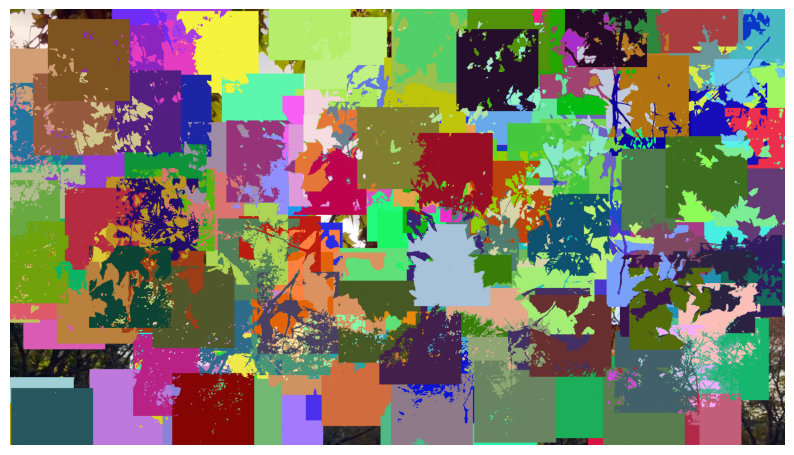

New Error: 50876.19170399376


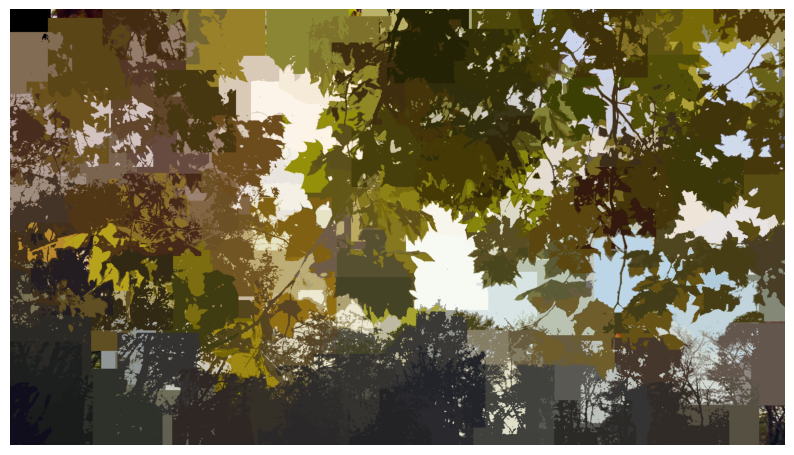

New Error: 11988.854794200433


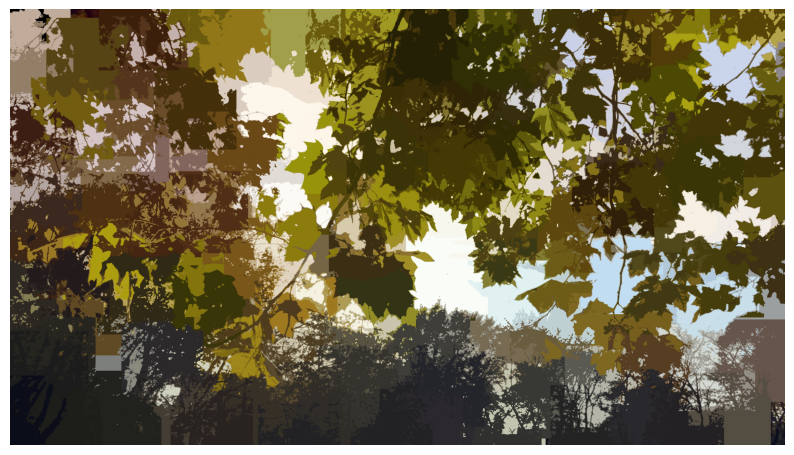

New Error: 6605.926377804075


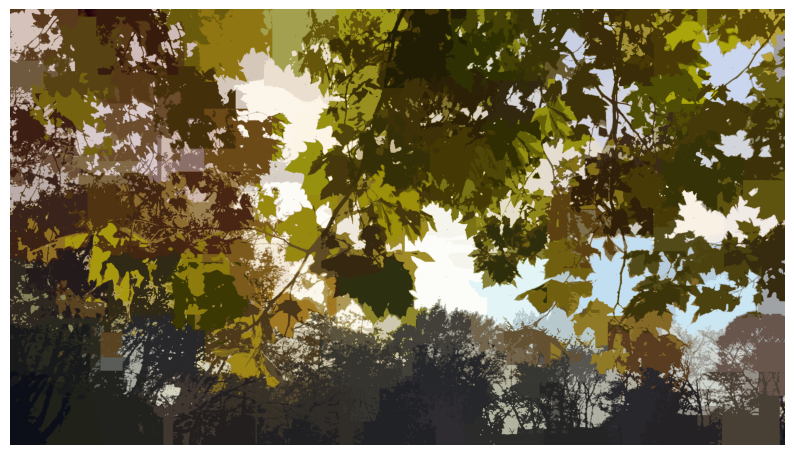

New Error: 4128.084471704855


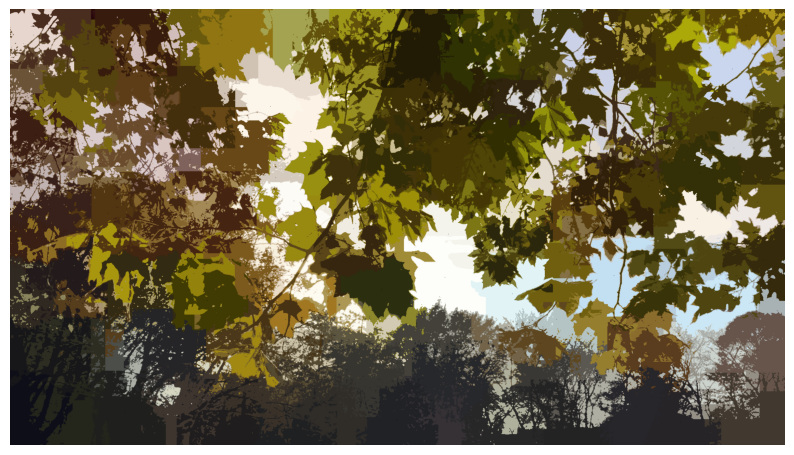

New Error: 2963.5760759243553


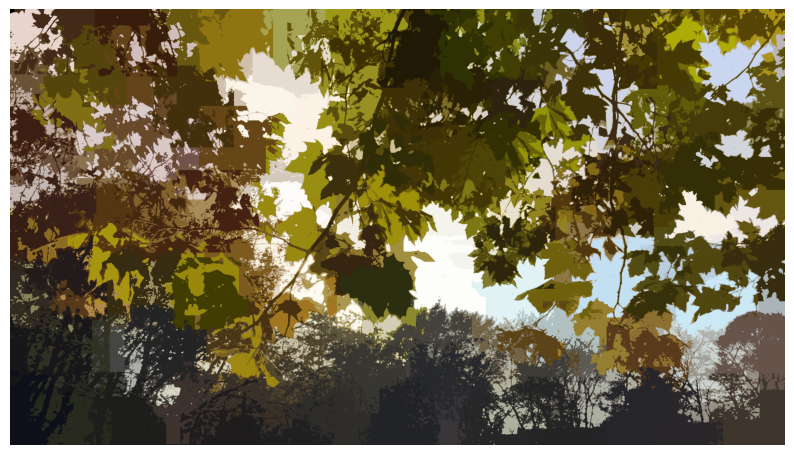

New Error: 2738.802593978509


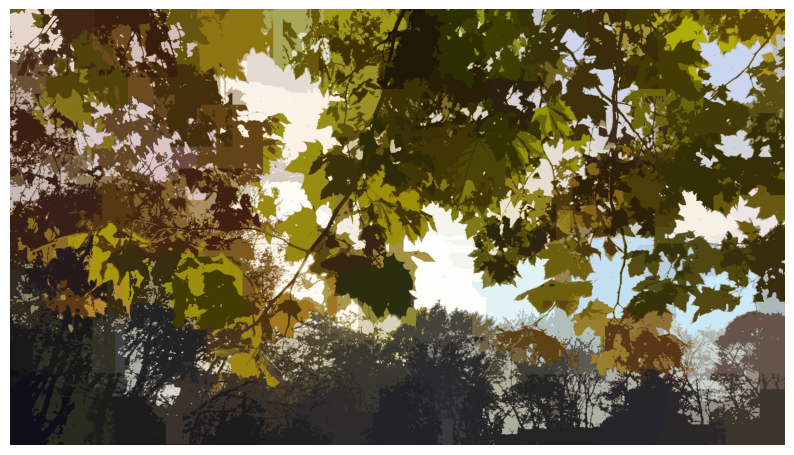

New Error: 2341.104346606701


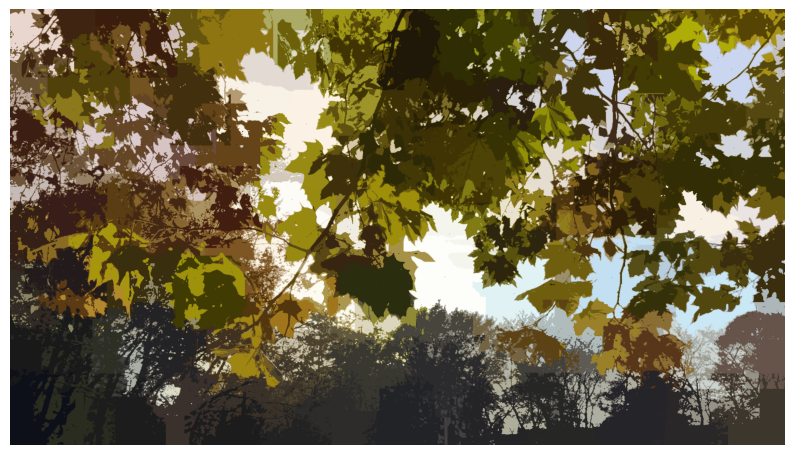

New Error: 2230.87446234278


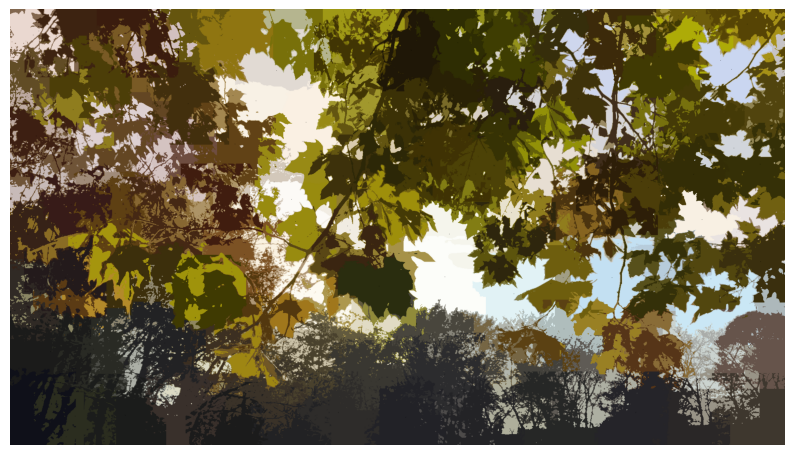

New Error: 1948.8504963280711


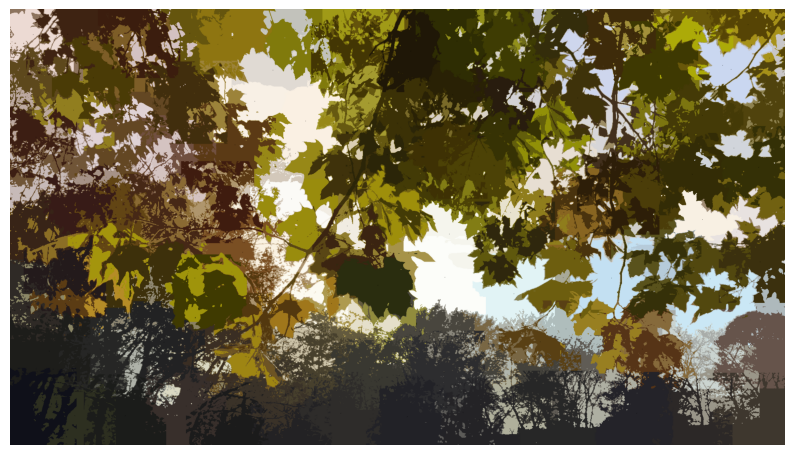

New Error: 1562.242887490413


In [7]:
rgb_slic_object = SLIC(image_rgb, 200, 20, -1, 10, 'RGB')
final_error, rgb_cluster_centers, segmented_rgb_image = rgb_slic_object.run()

### Video Part 

In [8]:
### Getting 11 frames from frames folder
import os
frames = []
frame_count = 11
frames_path = 'frames'
for i in range(frame_count):
    frame = cv2.imread(os.path.join(frames_path, f'frame_{str(i+65).zfill(4)}.jpg'))
    frames.append(frame)

# Convert to LAB Space
frames_lab = [rgb2lab(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)) for frame in frames]

# Convert frames to numpy array
frames = np.array(frames)
frames_lab = np.array(frames_lab)

In [ ]:
print(frames_lab.shape)

# Plot all images in frames_lab
fig, axes = plt.subplots(1, len(frames_lab), figsize=(20, 5))
for ax, frame in zip(axes, frames_lab):
    ax.imshow(lab2rgb(frame))
    ax.axis('off')
plt.show()

In [10]:
import concurrent.futures
import numpy as np
import time

def process_frames_in_parallel(frames_lab, threshold = -1, max_iter = 10 ,cluster_centers=None):
    def slic_on_frame(frame):
        try:
            slic_object = SLIC(frame, 200, 20, threshold, max_iter, 'LAB', False, cluster_centers)
            _, _, segmented_rgb_image = slic_object.run()
            return segmented_rgb_image
        except Exception as e:
            print(f"Error processing frame: {e}")
            return None

    start = time.time()

    # Use ThreadPoolExecutor for better NumPy compatibility
    with concurrent.futures.ThreadPoolExecutor() as executor:
        results = list(executor.map(slic_on_frame, frames_lab))

    # Remove None values if any
    results = [res for res in results if res is not None]

    # Convert to NumPy array safely
    if results:
        slic_frames = np.stack(results, axis=0)
    else:
        slic_frames = np.array([])  # Empty case

    end = time.time()
    print(f"Processing time: {end - start:.2f} seconds")
    print(f"Final shape: {slic_frames.shape}")

    return slic_frames

# Call the function
slic_frames = process_frames_in_parallel(frames_lab)

New Error: 82942.14678904462
New Error: 99117.05013740019
New Error: 73800.35089573539
New Error: 74382.78556607994
New Error: 86773.86339655118
New Error: 88704.41184511277
New Error: 89582.01693210409
New Error: 73849.82373610565
New Error: 80855.85133554984
New Error: 81733.85506096258
New Error: 76031.8336076513
New Error: 5761.101879781469
New Error: 5788.9599988690525
New Error: 6165.366956128276
New Error: 6027.149379248326
New Error: 6034.788253452386
New Error: 6148.844038531351
New Error: 6095.85948318427
New Error: 5553.054582574112
New Error: 5975.908085900456
New Error: 5879.224095869622
New Error: 6648.68200176443
New Error: 3534.124119922585
New Error: 3488.8592340034575
New Error: 3754.8299477287032
New Error: 3561.356689772477
New Error: 3120.779247037505
New Error: 3974.7909439835444
New Error: 3502.3303990446457
New Error: 3389.7077374219625
New Error: 3578.7229595860385
New Error: 3787.4031016167314
New Error: 3298.4573869913665
New Error: 2328.6018753708395
New Err

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [11]:
# Write the segmented frames to disk
output_folder = 'slic_frames'
os.makedirs(output_folder, exist_ok=True)
for i, slic_frame in enumerate(slic_frames):

    slic_frame = np.asarray(slic_frame * 255, dtype=np.uint8)
    slic_frame_bgr = cv2.cvtColor(slic_frame, cv2.COLOR_RGB2BGR)
    # Convert slic_frame to image
    # print(slic_frame.shape)
    # #Plot slic frame
    # plt.figure(figsize=(10, 10))
    # plt.imshow(slic_frame)
    # plt.axis('off')
    # plt.show(block=False)
    output_path = os.path.join(output_folder, f'slic_frame_{str(i+65).zfill(4)}.jpg')
    cv2.imwrite(output_path, slic_frame_bgr)
    

### Optimizing Segmentation video

In [12]:
# Plan
# Run SLIC on first frame normally
# Extract cluster centers and error
# Run SLIC on remaining frames in parallel
# with extracted cluster centers as initialisation and error +- threshold as stopping criteria


# Run SLIC on first frame normally
slic_object = SLIC(frames_lab[0], 200, 20, -1, 10, 'LAB', False)
final_error, cluster_centers, segmented_rgb_image = slic_object.run()
slic_frame_0 = segmented_rgb_image

New Error: 75334.69101920752
New Error: 6634.274813704224
New Error: 3815.271073071158
New Error: 2915.7780901892193
New Error: 2203.7010641587317
New Error: 1721.1408883613572
New Error: 1406.0075221783552
New Error: 1269.505015287619
New Error: 1151.9634398688495
New Error: 964.1355412145816


<Figure size 1000x1000 with 0 Axes>

In [13]:
thresh = 100
stopping_criteria = final_error - thresh

# parallize on all other frames, max of 20 iterations
slic_frames = process_frames_in_parallel(frames_lab[1:], stopping_criteria, 20, cluster_centers)

New Error: 964.0482502633438
New Error: 5190.283143761517
New Error: 2091.5467929978913
New Error: 2949.5777842136667
New Error: 4350.103605037703
New Error: 1111.7828288927583
New Error: 2517.183026880385
New Error: 1330.0631432353312
New Error: 1693.0140697391348
New Error: 4746.903718084149
New Error: 728.099770317675
New Error: 1374.5803800638205
New Error: 995.7024062271522
New Error: 1232.0987370899416
New Error: 1087.4359897007025
New Error: 745.8358355266264
New Error: 892.7591674720342
New Error: 801.2553070959115
New Error: 1330.2936247778764
New Error: 1242.7613638686723
New Error: 1011.755337944529
New Error: 756.0430958840211
New Error: 844.3227794019047
New Error: 844.2457310213105
New Error: 841.670704085724
New Error: 709.7291106089798
New Error: 960.3697599785136
New Error: 746.2946577417533
New Error: 720.6338086210233
Processing time: 30.33 seconds
Final shape: (10, 1080, 1920, 3)


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [14]:
# Ensure slic_frame_0 has the same shape as individual frames in slic_frames
slic_frame_0 = np.expand_dims(slic_frame_0, axis=0)

# Concatenate slic_frame_0 and slic_frames
all_slic_frames = np.concatenate((slic_frame_0, slic_frames), axis=0)
print(all_slic_frames.shape)

(11, 1080, 1920, 3)


In [15]:
# Write the segmented frames to disk
output_folder = 'slic_frames_optimized'
os.makedirs(output_folder, exist_ok=True)
for i, slic_frame in enumerate(all_slic_frames):

    slic_frame = np.asarray(slic_frame * 255, dtype=np.uint8)
    slic_frame_bgr = cv2.cvtColor(slic_frame, cv2.COLOR_RGB2BGR)
    # Convert slic_frame to image
    # print(slic_frame.shape)
    # #Plot slic frame
    # plt.figure(figsize=(10, 10))
    # plt.imshow(slic_frame)
    # plt.axis('off')
    # plt.show(block=False)
    output_path = os.path.join(output_folder, f'slic_frame_{str(i+65).zfill(4)}.jpg')
    cv2.imwrite(output_path, slic_frame_bgr)

In [16]:
### Convert these frames to a video Yay!

def create_video(frame_paths, output_video_path, fps):
    if not frame_paths:
        print("No frames to create a video.")
        return
    # print("Yo")
    first_frame = cv2.imread(frame_paths[0])
    height, width, layers = first_frame.shape
    frame_size = (width, height)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v') 
    out = cv2.VideoWriter(output_video_path, fourcc, fps, frame_size)

    for frame_path in frame_paths:
        frame = cv2.imread(frame_path)
        out.write(frame)  

    out.release()
    print(f"Video saved to {output_video_path}")


output_folder = "frames"       
output_video_path = "output_video/slic_frames.mp4" 
fps = 10

frame_paths = [f'slic_frames/slic_frame_00{i}.jpg' for i in range(65, 76)]
create_video(frame_paths, output_video_path, fps)


output_video_path_optimized = "output_video/slic_frames_optimized.mp4"
frame_paths_optimized = [f'slic_frames_optimized/slic_frame_00{i}.jpg' for i in range(65, 76)]
create_video(frame_paths_optimized, output_video_path_optimized, fps)



Video saved to output_video/slic_frames.mp4
Video saved to output_video/slic_frames_optimized.mp4
